## データベースの作成、接続 　　スクレイピングの実施

In [276]:
import requests
from bs4 import BeautifulSoup
import sqlite3

urls = [
    'https://www.jalan.net/110000/LRG_110200/', 
    'https://www.jalan.net/110000/LRG_111400/', 
    'https://www.jalan.net/110000/LRG_111700/', 
    'https://www.jalan.net/110000/LRG_110500/', 
    'https://www.jalan.net/110000/LRG_111100/', 
    'https://www.jalan.net/110000/LRG_110800/'
]

# データベース接続時にエンコーディングを指定
conn = sqlite3.connect('hotels.db')
conn.execute('pragma encoding=utf8')
cursor = conn.cursor()

# hotelsテーブルが存在しない場合は作成
cursor.execute('''
    CREATE TABLE IF NOT EXISTS hotels (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT,
        price TEXT,
        rating TEXT,
        review_count TEXT,
        access TEXT
    )
''')

hotel_data_list = []
total_hotels = 0

for url in urls:
    response = requests.get(url)
    response.raise_for_status()

    soup = BeautifulSoup(response.content, 'html.parser')
    hotels = soup.find_all('div', class_='p-yadoCassette__summary')

    for hotel in hotels:
        name_element = hotel.select_one("h2.p-searchResultItem__facilityName")
        name = name_element.text.strip() if name_element else "情報なし"

        price_element = hotel.select_one("span.p-searchResultItem__lowestPriceValue")
        price = price_element.text.strip() if price_element else "情報なし"

        rating_element = hotel.select_one("span.p-searchResultItem__summaryaverage-num")
        rating = rating_element.text.strip() if rating_element else "情報なし"

        comments_element = hotel.select_one("span.p-searchResultItem__summarykuchikomi__totalNumber")
        review_count = comments_element.text.strip() if comments_element else "情報なし"

        access_element = hotel.select_one("dd.p-searchResultItem__accessValue")
        access = access_element.text.strip() if access_element else "情報なし"

        # データベースに挿入する前に文字列をUTF-8に変換する
        name = name.encode('utf-8') 
        price = price.encode('utf-8') 
        rating = rating.encode('utf-8') 
        review_count = review_count.encode('utf-8') 
        access = access.encode('utf-8') 

        hotel_data_list.append((name, price, rating, review_count, access))
        total_hotels += 1

# データベースへの挿入
cursor.executemany('''
    INSERT INTO hotels (name, price, rating, review_count, access)
    VALUES (?, ?, ?, ?, ?)
''', hotel_data_list)

# 変更をコミットして接続を閉じる
conn.commit()
conn.close()

print("-" * 30)
print(f"読み込んだホテル数: {total_hotels}")

------------------------------
読み込んだホテル数: 144


## 相関係数　価格と評価とレビューのヒストグラム　ヒートマップ

相関係数:
                 price    rating  review_count
price         1.000000  0.422715      0.061267
rating        0.422715  1.000000     -0.087947
review_count  0.061267 -0.087947      1.000000


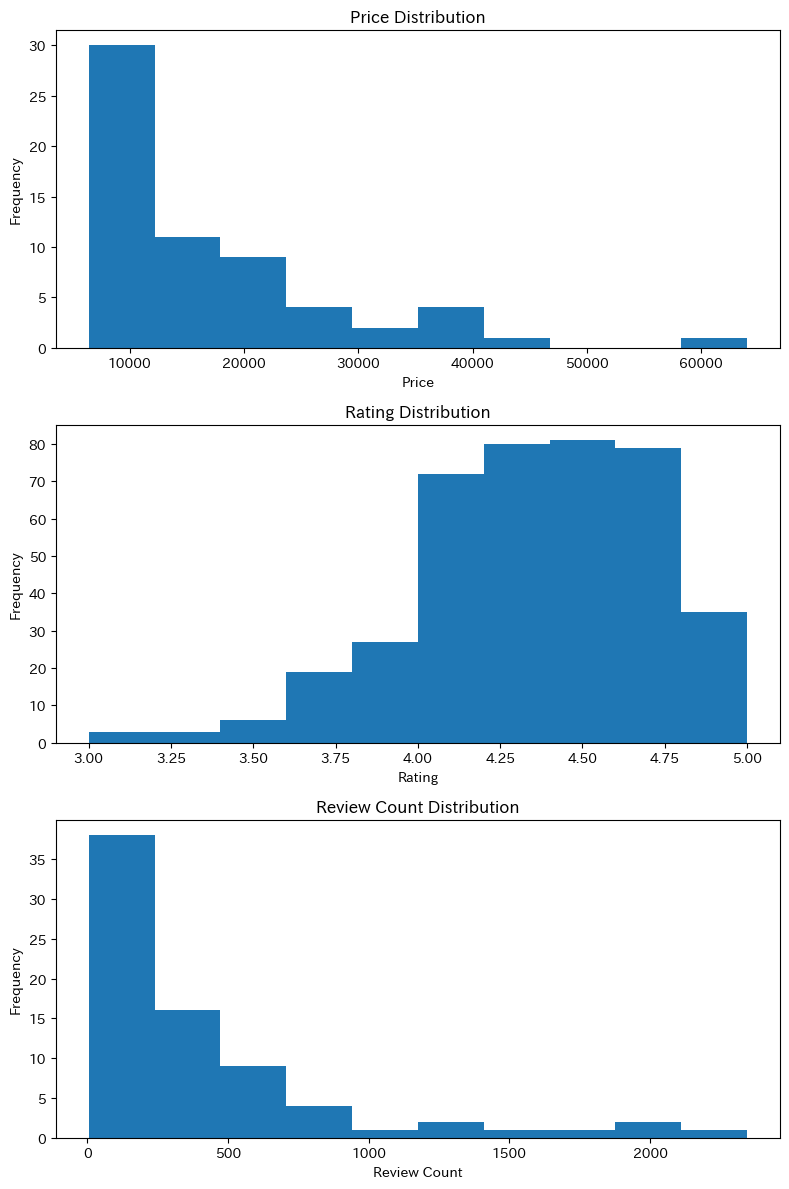

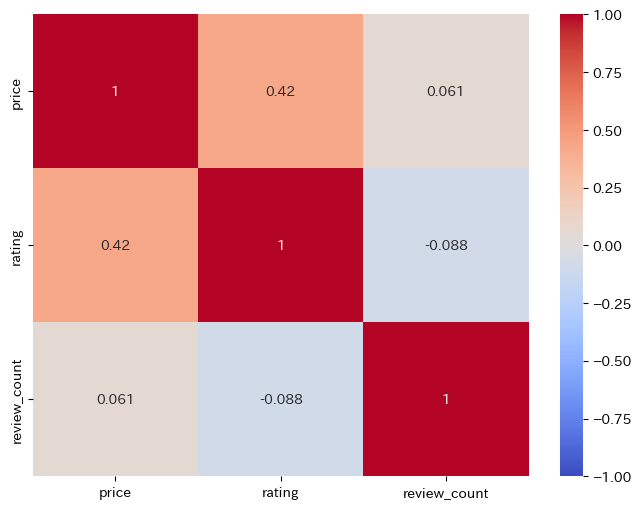

In [277]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# データベース接続
conn = sqlite3.connect('hotels.db')

# SQLクエリを実行してデータを取得 (id を除く)
df = pd.read_sql_query("SELECT name, price, rating, review_count, access FROM hotels", conn)

# データベース接続を閉じる
conn.close()

# price, rating, review_count を数値に変換
df['price'] = pd.to_numeric(df['price'].str.replace('円〜', '').str.replace(',', ''), errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['review_count'] = pd.to_numeric(df['review_count'].str.replace('件', '').str.replace(',', ''), errors='coerce')

# 相関行列の計算
correlation_matrix = df[['price', 'rating', 'review_count']].corr()

# 相関係数を表示
print("相関係数:")
print(correlation_matrix.to_string())  # 見やすいように整形して表示

# ヒストグラム
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12)) 

# priceのヒストグラム
axes[0].hist(df['price'], bins=10)
axes[0].set_title('Price Distribution')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# ratingのヒストグラム
axes[1].hist(df['rating'], bins=10)
axes[1].set_title('Rating Distribution')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Frequency')

# review_countのヒストグラム
axes[2].hist(df['review_count'], bins=10)
axes[2].set_title('Review Count Distribution')
axes[2].set_xlabel('Review Count')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# ヒートマップ
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

## レビューと評価の影響

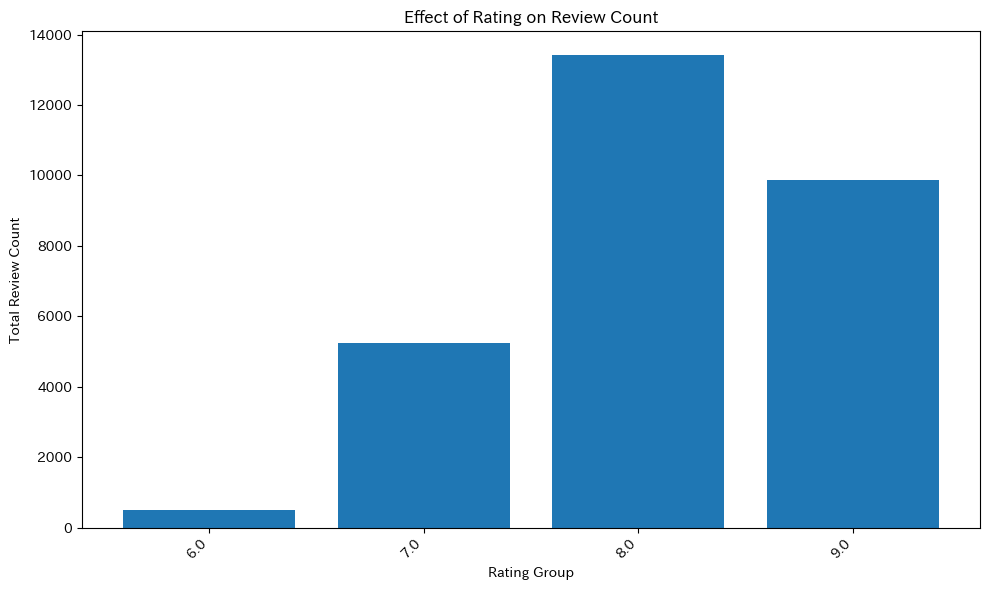

In [278]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# データベース接続
conn = sqlite3.connect('hotels.db')

# SQLクエリを実行してデータを取得
df = pd.read_sql_query("SELECT rating, review_count FROM hotels", conn)

# データベース接続を閉じる
conn.close()

# rating, review_count を数値に変換
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['review_count'] = pd.to_numeric(df['review_count'].str.replace('件', '').str.replace(',', ''), errors='coerce')

# 評価をグループ分け (例: 0.5刻み)
rating_bins = [i * 0.5 for i in range(11)]  # 0.0, 0.5, 1.0, ..., 5.0
df['rating_group'] = pd.cut(df['rating'], bins=rating_bins, labels=False, right=False)

# 評価グループごとのレビュー数を集計
review_counts = df.groupby('rating_group')['review_count'].sum()

# ヒストグラムを描画
plt.figure(figsize=(10, 6))
plt.bar(review_counts.index.astype(str), review_counts.values) 
plt.xlabel('Rating Group')
plt.ylabel('Total Review Count')
plt.title('Effect of Rating on Review Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()